In [1]:
import os
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential, model_from_json
from keras.layers.core import Dense
from keras.optimizers import RMSprop

In [2]:
def read_df(path):
    df = pd.read_csv(path, sep=',')
    return df

# df = read_df('20190101-20200829-takamatsu.csv')
# df = df.drop(['dew‐point_temperature', 'wind_direction'], axis=1)
# df.to_csv('20190101-20200829-takamatsu.csv', index=False)

In [3]:
def minxmax_scaler(df, isdf):
    scaler = MinMaxScaler()
    scaler.fit(df)
    if isdf: # 正規化したデータを新規のデータフレームに
        mc = pd.DataFrame(scaler.transform(df), columns=df.columns) 
    else:  # 正規化したデータをリストに
        mc = scaler.fit_transform(df)

    return mc

In [4]:
def pairplot(df):
    df = df.drop(['datetime', 'year'], axis=1)
    plt.figure()
    sns.pairplot(df)
    plt.savefig('figure/pairplot.png')

In [5]:
def corr_heatmap(df):
    df = df.drop(['datetime', 'year'], axis=1)
    cor = df.corr() # 相関
    plt.figure()
    sns.heatmap(cor, cmap= sns.color_palette('coolwarm', 10), annot=True,fmt='.2f', vmin = -1, vmax = 1)
    plt.savefig('figure/corr_heatmap.png')

In [6]:
def extract_train_test_data(df):
    train_df = df[df['year'] == 2019]
    test_df = df[(df['year'] == 2020)]
    # test_df = df[(df['year'] == 2020) & (df['month'] == 8) & (df['day'] == 11)]
    
    # プロット
    # pairplot(train_df) 
    # corr_heatmap(train_df)

    return train_df, test_df

# df = read_df('20190101-20200829-takamatsu.csv')
# train_df, test_df = extract_train_test_data(df)
# plt.figure(figsize=(16,4))
# plt.plot(train_df['day_length'])
# # plt.plot(test_df['month'])
# plt.xlim(0,24)
# plt.show()

In [7]:
def make_train_test_data(df, col_list):
    train_df, test_df = extract_train_test_data(df)
    # train_df = train_df[train_df['month']<=8]
    # 学習用、テスト用にデータを分割
    X_train = minxmax_scaler(train_df[col_list], True)
    y_train = train_df['temperature']
    X_test = minxmax_scaler(test_df[col_list], True)
    y_test = test_df['temperature']

    return X_train, y_train, X_test, y_test

In [8]:
def learn_model(X_train, y_train, input_num, batch_size, epochs):
    model = Sequential()
    # 入力層
    model.add(Dense(10, activation='sigmoid', input_shape=(input_num,)))
    # 出力層
    model.add(Dense(1, activation='linear'))
    # コンパイル（勾配法：RMSprop、損失関数：mean_squared_error、評価関数：accuracy）
    model.compile(loss='mean_squared_error', optimizer=RMSprop(), metrics=['accuracy'])
    # 構築したモデルで学習
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)
    
    # モデルの性能評価
    score = model.evaluate(X_train, y_train, verbose=0)
    print('Score:', score[0])    # 損失値
    print('Accuracy:', score[1]) # 精度

    return history, model

In [9]:
def save_leaning_history(history):
    # 精度
    plt.figure(figsize=(4,3))
    plt.plot(history.history['accuracy'])
    plt.title('accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    # plt.savefig('figure/accuracy.png')
    plt.show()

    # 損失
    plt.figure(figsize=(4,3))
    plt.plot(history.history['loss'])
    plt.title("loss")
    plt.ylabel('loss')
    plt.xlabel('epoch')
    # plt.savefig('figure/loss.png')
    plt.show()

In [10]:
def save_predict_graph(y_pre, y_test):
    plt.figure(figsize=(16,4))
    plt.plot(y_test, label='fact')
    plt.plot(y_pre, label='pred')
    plt.legend()
    # plt.xlim(0,100)
    # plt.savefig('figure/pre.png')
    plt.show()

In [11]:
def predict_model(X_test, y_test, model):    
    # モデルを使った予測
    y_pre = model.predict(X_test)
    
    # 予測と正解のグラフ作成
    save_predict_graph(y_pre, y_test.values)
    
    # 予測と正解の出力
    data = np.c_[y_test, y_pre]
    # np.savetxt('out.csv',data,delimiter=',')

    # 学習モデルの保存
    # model.save('and.h5')

In [12]:
# データ読み込み
df = read_df('20190101-20200829-takamatsu.csv')
df

,datetime,temperature,pressure,relative_humidity,wind_speed,rainfall,sea_level_pressure,day_length,year,month,day,hour
0,2019-01-01,0.8,1030.3,81.0,1.4,0.0,1031.7,0.0,2019,1,1,1
1,2019-01-01,0.3,1029.8,85.0,1.4,0.0,1031.2,0.0,2019,1,1,2
2,2019-01-01,0.8,1030.0,81.0,2.8,0.0,1031.4,0.0,2019,1,1,3
3,2019-01-01,0.1,1028.8,82.0,0.8,0.0,1030.2,0.0,2019,1,1,4
4,2019-01-01,0.0,1028.0,84.0,0.7,0.0,1029.4,0.0,2019,1,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...
14563,2020-08-29,31.8,1009.0,66.0,0.6,0.0,1010.2,0.0,2020,8,29,20
14564,2020-08-29,30.3,1009.7,76.0,2.2,0.0,1010.9,0.0,2020,8,29,21
14565,2020-08-29,30.1,1009.9,76.0,1.6,0.0,1011.1,0.0,2020,8,29,22
14566,2020-08-29,29.6,1009.8,74.0,1.7,0.0,1011.0,0.0,2020,8,29,23


In [13]:
# 学習、検証データ作成
col_list = ['relative_humidity', 'pressure', 'day_length', 'month', 'day', 'hour']
X_train, y_train, X_test, y_test = make_train_test_data(df, col_list)
X_train

,relative_humidity,pressure,day_length,month,day,hour
0,81.0,1030.3,0.0,1,1,1
1,85.0,1029.8,0.0,1,1,2
2,81.0,1030.0,0.0,1,1,3
3,82.0,1028.8,0.0,1,1,4
4,84.0,1028.0,0.0,1,1,5
...,...,...,...,...,...,...
8755,59.0,1025.0,0.0,12,31,20
8756,66.0,1025.5,0.0,12,31,21
8757,64.0,1025.8,0.0,12,31,22
8758,63.0,1025.9,0.0,12,31,23


In [14]:
# 学習
input_num = len(col_list)
batch_size = 20
epochs = 100
history, model = learn_model(X_train, y_train, input_num, batch_size, epochs)

Epoch 1/100
438/438 [==============================] - 1s 1ms/step - loss: 290.9991 - accuracy: 5.7078e-04
Epoch 2/100
438/438 [==============================] - 0s 1ms/step - loss: 210.6096 - accuracy: 5.7078e-04
Epoch 3/100
438/438 [==============================] - 0s 800us/step - loss: 149.0112 - accuracy: 5.7078e-04
Epoch 4/100
438/438 [==============================] - 1s 1ms/step - loss: 105.6843 - accuracy: 5.7078e-04
Epoch 5/100
438/438 [==============================] - 1s 2ms/step - loss: 80.9868 - accuracy: 5.7078e-04
Epoch 6/100
438/438 [==============================] - 1s 1ms/step - loss: 72.0206 - accuracy: 5.7078e-04
Epoch 7/100
438/438 [==============================] - 0s 914us/step - loss: 70.6944 - accuracy: 5.7078e-04
Epoch 8/100
438/438 [==============================] - 0s 1ms/step - loss: 70.6058 - accuracy: 5.7078e-04
Epoch 9/100
438/438 [==============================] - 1s 1ms/step - loss: 70.6078 - accuracy: 5.7078e-04
Epoch 10/100
438/438 [================

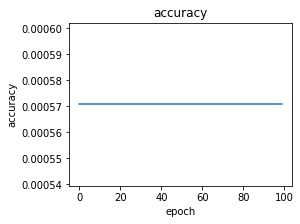

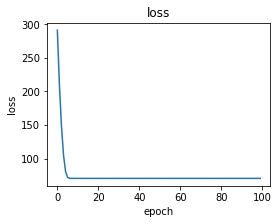

In [15]:
#　学習曲線保存
save_leaning_history(history)

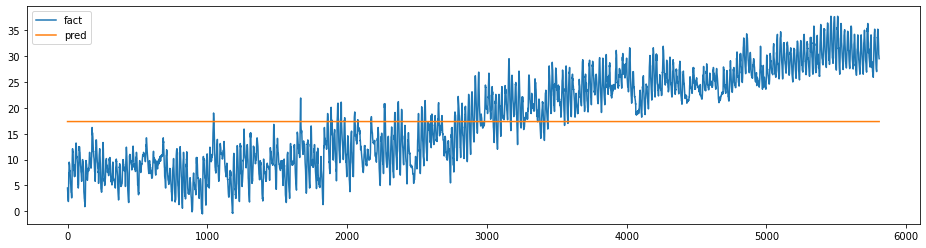

In [16]:
# 予測
predict_model(X_test, y_test, model)